# Latency Lab Analysis

This notebook reads `results/index.csv` and shows basic comparisons.


In [1]:
import sys
from pathlib import Path

def find_repo_root(start: Path) -> Path:
    for parent in [start] + list(start.parents):
        if (parent / "scripts" / "results_lib.py").exists():
            return parent
    return start

repo_root = find_repo_root(Path().resolve())
sys.path.append(str(repo_root / "scripts"))

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from results_lib import load_index, load_samples

sns.set_theme(style="whitegrid")


## Run benchmarks from the notebook

Use this helper to launch a benchmark and print the latest stdout summary.


In [2]:
import sys
from pathlib import Path

import ipywidgets as widgets
from IPython.display import display, clear_output

def find_repo_root(start: Path) -> Path:
    for parent in [start] + list(start.parents):
        if (parent / "scripts" / "notebook_runner.py").exists():
            return parent
    return start

repo_root = find_repo_root(Path().resolve())
scripts_dir = repo_root / "scripts"
if str(scripts_dir) not in sys.path:
    sys.path.append(str(scripts_dir))

import notebook_runner as nb

bench_path = repo_root / "build" / "bench"
results_dir = repo_root / "results"

try:
    cases = nb.list_cases(bench_path)
except Exception as exc:
    cases = ["noop"]
    print(f"Could not list cases: {exc}")
    print(f"Build bench at {bench_path} to populate the dropdown.")

case = widgets.Dropdown(options=cases, description="Case")
lab = widgets.Text(value="os", description="Lab")
iters = widgets.IntText(value=10000, description="Iters")
warmup = widgets.IntText(value=1000, description="Warmup")
pin_cpu = widgets.IntText(value=-1, description="Pin CPU")
tags = widgets.Text(value="quiet", description="Tags (csv)")
run_button = widgets.Button(description="Run")
output = widgets.Output()

def run_clicked(_):
    with output:
        clear_output()
        tag_list = [t.strip() for t in tags.value.split(",") if t.strip()]
        pin = None if pin_cpu.value < 0 else pin_cpu.value
        try:
            result = nb.run_case(
                bench_path=bench_path,
                lab=lab.value,
                case=case.value,
                results_dir=results_dir,
                iters=iters.value,
                warmup=warmup.value,
                pin_cpu=pin,
                tags=tag_list,
            )
        except Exception as exc:
            print(f"Run failed: {exc}")
            return
        print(f"Run dir: {result.run_dir}")
        print(result.read_stdout())

run_button.on_click(run_clicked)
display(widgets.VBox([case, lab, iters, warmup, pin_cpu, tags, run_button]), output)


Output()

In [3]:
index = load_index(repo_root / "results" / "index.csv")

if hasattr(index, "columns") and "run_dir" in index.columns:
    def _abs_run_dir(value):
        if not isinstance(value, str) or not value:
            return value
        path = Path(value)
        if path.is_absolute():
            return value
        return str((repo_root / path).resolve())

    index["run_dir"] = index["run_dir"].apply(_abs_run_dir)

index.head()


,lab,case,tags,iters,warmup,pin_cpu,unit,min,p50,p95,...,run_dir,summary_path,meta_path,stdout_path,raw_csv_path,raw_llr_path,raw_unit,bench_path,bench_args,started_at
0,os,fork_exec_wait,"[""quiet""]",10000,1000,-1,ns,385759,455784,501119,...,/home/dan/dev/git/latency-lab/results/os/fork_...,/home/dan/dev/git/latency-lab/results/os/fork_...,/home/dan/dev/git/latency-lab/results/os/fork_...,/home/dan/dev/git/latency-lab/results/os/fork_...,/home/dan/dev/git/latency-lab/results/os/fork_...,/home/dan/dev/git/latency-lab/results/os/fork_...,us,/home/dan/dev/git/latency-lab/build/bench,[],2026-01-24T10:41:50


In [4]:
# Pick a case to compare pinned vs unpinned (adjust as needed)
case_name = index["case"].iloc[0] if len(index) else "noop"
subset = index[index["case"] == case_name]

display(subset[["case","tags","pin_cpu","p50","p95","p99","p999","mean"]])


,case,tags,pin_cpu,p50,p95,p99,p999,mean
0,fork_exec_wait,"[""quiet""]",-1,455784,501119,542470,617742,457829.8747


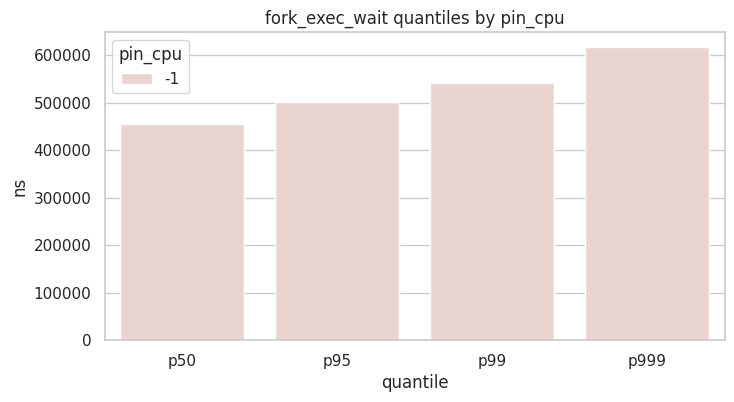

In [5]:
# Long-form view of quantiles for the chosen case
if len(subset):
    plot_df = subset.melt(
        id_vars=["tags","pin_cpu"],
        value_vars=["p50","p95","p99","p999"],
        var_name="quantile",
        value_name="ns",
    )
    plt.figure(figsize=(8,4))
    sns.barplot(data=plot_df, x="quantile", y="ns", hue="pin_cpu")
    plt.title(f"{case_name} quantiles by pin_cpu")
    plt.show()


In [6]:
# ECDF of raw samples for the first two runs (if raw data is present)
if len(index) >= 2:
    run_a = index.iloc[0]["run_dir"]
    run_b = index.iloc[1]["run_dir"]
    samples_a = load_samples(run_a)
    samples_b = load_samples(run_b)

    plt.figure(figsize=(8,4))
    sns.ecdfplot(samples_a, label=str(run_a))
    sns.ecdfplot(samples_b, label=str(run_b))
    plt.xlabel("ns")
    plt.ylabel("ECDF")
    plt.legend()
    plt.title("ECDF comparison")
    plt.show()
